# Measurement noise assessment

In this notebook, we illustrate how to use pyABC with different noise models. For simplicity, we use a simple ODE model of a conversion reaction. For simplicity, we consider a single parameter:

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyabc
%matplotlib inline

init = np.array([1, 0])

def f(y, t0, theta1, theta2=np.exp(-2)):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2

theta1_true = np.exp(-2.5)
theta_true = {'theta1': theta1_true}

prior = pyabc.Distribution(
    theta1=pyabc.RV("uniform", 0, 0.2))

measurement_times = np.arange(10)

We assume that the underlying dynamics of our observations follow the following model:

In [2]:
def model(pars):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],))
    return {'X_2': sol[:,1]}

true_trajectory = model(theta_true)

However, we assume that our measurements are subject to additive Gaussian noise:

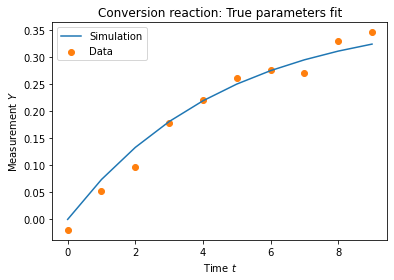

In [3]:
sigma = 0.02

def model_noisy(pars):
    sim = model(pars)
    return {'X_2': sim['X_2'] + sigma * np.random.randn(10)}

measured_data = model_noisy(theta_true)

# plot data
plt.plot(true_trajectory['X_2'], color="C0", label='Simulation')
plt.scatter(measurement_times, measured_data['X_2'],
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

In the notebook "Ordinary Differential Equations: Conversion Reaction", this model is used without accounting for a noise model, which is strictly speaking not correct. In this case, we get the following result:

In [4]:
def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history = abc.run(max_nr_populations=10)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2020-05-17 19:20:02.057717, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.084172147868104
INFO:ABC:t: 0, eps: 1.084172147868104.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.5454037806851662.
INFO:ABC:Acceptance rate: 100 / 203 = 4.9261e-01, ESS=9.9506e+01.
INFO:ABC:t: 2, eps: 0.30743348110077184.
INFO:ABC:Acceptance rate: 100 / 204 = 4.9020e-01, ESS=9.9191e+01.
INFO:ABC:t: 3, eps: 0.2102967303073575.
INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=9.9378e+01.
INFO:ABC:t: 4, eps: 0.1770449335236894.
INFO:ABC:Acceptance rate: 100 / 189 = 5.2910e-01, ESS=9.7765e+01.
INFO:ABC:t: 5, eps: 0.16298972834364076.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=9.9892e+01.
INFO:ABC:t: 6, eps: 0.1578357659925425.
INFO:ABC:Acceptance rate: 100 / 250 = 4.0000e-01, ESS=9.9636e+01.
INFO:ABC:t: 7, eps: 0.15522

As one can see in the below plot, this converges to a point estimate as $\varepsilon\rightarrow 0$, and does not correctly represent the posterior. In particular, in general this point estimate will not capture the correct parameter value (indicated by the grey line).

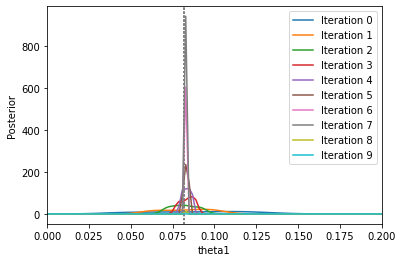

In [5]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="theta1", t=t, refval=theta_true, refval_color='grey',
        xmin=0, xmax=0.2, numx=100, ax=ax, label=f"Iteration {t}")
ax.legend()
plt.show()

To correctly account for noise, there are essentially two possibilities: Firstly, we can use the noisified model output:

In [6]:
abc = pyabc.ABCSMC(model_noisy, prior, distance)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_noisy_output = abc.run(max_nr_populations=10)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=2, start_time=2020-05-17 19:20:08.111977, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.0800670507653136
INFO:ABC:t: 0, eps: 1.0800670507653136.
INFO:ABC:Acceptance rate: 100 / 212 = 4.7170e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.6371288204166492.
INFO:ABC:Acceptance rate: 100 / 201 = 4.9751e-01, ESS=9.9760e+01.
INFO:ABC:t: 2, eps: 0.3770224852218239.
INFO:ABC:Acceptance rate: 100 / 187 = 5.3476e-01, ESS=9.9599e+01.
INFO:ABC:t: 3, eps: 0.27592677713707864.
INFO:ABC:Acceptance rate: 100 / 221 = 4.5249e-01, ESS=9.7964e+01.
INFO:ABC:t: 4, eps: 0.22583551666702822.
INFO:ABC:Acceptance rate: 100 / 318 = 3.1447e-01, ESS=8.8799e+01.
INFO:ABC:t: 5, eps: 0.19095656457615162.
INFO:ABC:Acceptance rate: 100 / 514 = 1.9455e-01, ESS=8.7841e+01.
INFO:ABC:t: 6, eps: 0.17510413550361392.
INFO:ABC:Acceptance rate: 100 / 899 = 1.1123e-01, ESS=8.1135e+01.
INFO:ABC:t: 7, eps: 0.1

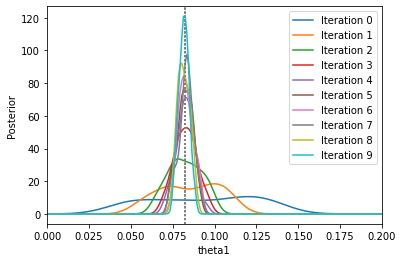

In [7]:
_, ax = plt.subplots()
for t in range(history_noisy_output.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_noisy_output, x="theta1", t=t,
        refval=theta_true, refval_color='grey',
        xmin=0, xmax=0.2, ax=ax, numx=200, label=f"Iteration {t}")
ax.legend()

This curve is much broader and, as one can show, closer to the correct posterior.

Secondly, we can alternatively use the non-noisy model, but adjust the acceptance step:

In [8]:
acceptor = pyabc.StochasticAcceptor()
kernel = pyabc.IndependentNormalKernel(var=sigma**2)
eps = pyabc.Temperature()

abc = pyabc.ABCSMC(model, prior, kernel, eps=eps, acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_acceptor = abc.run(max_nr_populations=10)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=3, start_time=2020-05-17 19:20:21.467597, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 71.39682215804339.
INFO:ABC:Acceptance rate: 100 / 305 = 3.2787e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 8.10638270618757.
INFO:ABC:Acceptance rate: 100 / 347 = 2.8818e-01, ESS=9.9611e+01.
INFO:ABC:t: 2, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 348 = 2.8736e-01, ESS=9.9490e+01.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=3, start_time=2020-05-17 19:20:21.467597, end_time=2020-05-17 19:20:24.502474)>


We use a `pyabc.StochasticAcceptor` for the acceptor, replacing the default `pyabc.UniformAcceptor`, in order to accept when

$$\frac{\pi(D|y,\theta)}{c}\geq[0,1],$$
    
where $\pi(D|y,\theta)$ denotes the distribution of noisy data $D$ given non-noisy model output $y$ and parameters $\theta$. Here, we use a `pyabc.IndependentNormalKernel` in place of a `pyabc.Distance` to capture the normal noise $\pi(D|y,\theta)\sim\mathcal{N}(D|y,\theta,\sigma)$. Also other noise models are possible, including Laplace or binomial noise. In place of the `pyabc.Epsilon`, we employ a `pyabc.Temperature` which implements schemes to decrease a temperature $T\searrow 1$, s.t. in iteration $t$ we sample from

$$\pi(\theta,y|D) \propto \pi(D|y,\theta)^{1/T_t}p(y|\theta)\pi(\theta),$$

where $p(y|\theta)$ denotes the model output likelihood, and $\pi(\theta)$ the parameters prior.

Each of acceptor, kernel and temperature offers various configuration options, however the default parameters have shown to be quite stable already.

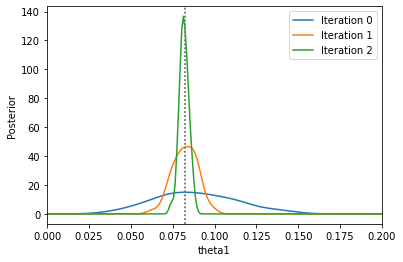

In [9]:
_, ax = plt.subplots()
for t in range(history_acceptor.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_acceptor, x="theta1", t=t,
        refval=theta_true, refval_color='grey',
        xmin=0, xmax=0.2, ax=ax, numx=200, label=f"Iteration {t}")
ax.legend()
plt.show()

We see that we get essentially the same posterior distribution as with the noisy output (a bit more peaked, showing that the approximation error with the noisy output was not negligible yet), however at a much lower computational cost, as the below plot shows:

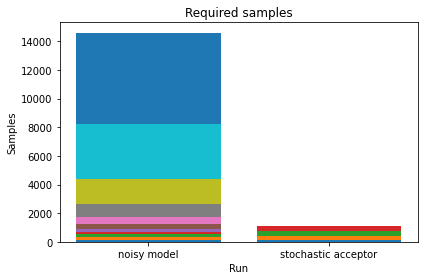

In [10]:
histories = [history_noisy_output, history_acceptor]
labels = ["noisy model", "stochastic acceptor"]

pyabc.visualization.plot_sample_numbers(histories, labels)
plt.show()

Thus, the stochastic acceptor is the proposed method to use in practice. For further details consult the API documentation.